In [1]:
from fastai.text import *
from fastai.vision import *
import spacy
from spacy import displacy
import scispacy
import librosa
import librosa.display
import soundfile as sf
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import IPython
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def get_wav_info(wav_file):
    data, rate = sf.read(wav_file)
    return data, rate

def create_spectrogram(wav_file):
    data, rate = get_wav_info(wav_file)
    nfft = 200 
    fs = 8000 
    noverlap = 120 
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def create_melspectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('data/spectrograms/' + name + '.jpg')
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

def wordBarGraphFunction(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

def wordCloudFunction(df,column,numWords):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=numWords,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [4]:
overview = pd.read_csv('data/overview-of-recordings.csv')
overview = overview[['file_name','phrase','prompt','overall_quality_of_the_audio','speaker_id']]
overview=overview.dropna()
overviewAudio = overview[['file_name','prompt']]
overviewAudio['spec_name'] = overviewAudio['file_name'].str.rstrip('.wav')
overviewAudio = overviewAudio[['spec_name','prompt']]
overviewText = overview[['phrase','prompt']]
noNaNcsv = 'data/overview-of-recordings.csv'
noNaNcsv = pd.read_csv(noNaNcsv)
noNaNcsv = noNaNcsv.dropna()
noNaNcsv = noNaNcsv.to_csv('overview-of-recordings.csv',index=False)
noNaNcsv

In [ ]:
overview[110:120]

In [ ]:
sns.set_style("whitegrid")
promptsPlot = sns.countplot(y='prompt',data=overview)
promptsPlot

qualityPlot = sns.FacetGrid(overview,aspect=2.5)
qualityPlot.map(sns.kdeplot,'overall_quality_of_the_audio',shade= True)
qualityPlot.set(xlim=(2.5, overview['overall_quality_of_the_audio'].max()))
qualityPlot.set_axis_labels('overall_quality_of_the_audio', 'Proportion')
qualityPlot

In [ ]:
overview[62:63]

In [ ]:
en_core_sci_sm = 'data/models/en_core_sci_sm-0.1.0/en_core_sci_sm/en_core_sci_sm-0.1.0'
nlp = spacy.load(en_core_sci_sm)
text = overview['phrase'][62]
doc = nlp(text)
print(list(doc.sents))
print(doc.ents)
displacy.render(next(doc.sents), style='dep', jupyter=True,options = {'compact': True, 'word_spacing': 45, 'distance': 90})

In [ ]:
IPython.display.Audio('data/recordings/test/1249120_20518958_23074828.wav')

In [ ]:
overview[118:119]

In [ ]:
en_core_sci_sm = 'data/models/en_core_sci_sm-0.1.0/en_core_sci_sm/en_core_sci_sm-0.1.0'
nlp = spacy.load(en_core_sci_sm)
text = overview['phrase'][118]
doc = nlp(text)
print(list(doc.sents))
print(doc.ents)
displacy.render(next(doc.sents), style='dep', jupyter=True,options = {'compact': True, 'word_spacing': 45, 'distance': 90})

In [ ]:
IPython.display.Audio('data/recordings/test/1249120_43788827_53247832.wav')

In [ ]:
plt.figure(figsize=(15,15))
wordCloudFunction(overview,'phrase',10000000)

In [ ]:
plt.figure(figsize=(10,10))
wordBarGraphFunction(overview,'phrase',"Most Common Words in Medical Text Transcripts")

In [ ]:
np.random.seed(7)
path = Path('data/')
data_clas = (TextList.from_csv(path, 'overview-of-recordings.csv', 
                               cols='phrase')
                   .random_split_by_pct(.2)
                   .label_from_df(cols='prompt')
                   .databunch(bs=42))
MODEL_PATH = "S2Smodel/"
learn = text_classifier_learner(data_clas,model_dir=MODEL_PATH,arch=AWD_LSTM)
learn.fit_one_cycle(5)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [ ]:
testAudio = "data/recordings/train/1249120_44176037_58635902.wav"
x = create_spectrogram(testAudio)

In [ ]:
filename = "data/recordings/train/1249120_44176037_58635902.wav"
clip, sample_rate = librosa.load(filename, sr=None)
fig = plt.figure(figsize=[5,5])
S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

In [ ]:
Data_dir_train=np.array(glob("data/recordings/train/*"))
Data_dir_test=np.array(glob("data/recordings/test/*"))
Data_dir_val=np.array(glob("data/recordings/validate/*"))

for file in tqdm(Data_dir_train):
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_melspectrogram(filename,name)
for file in tqdm(Data_dir_test):
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_melspectrogram(filename,name)
for file in tqdm(Data_dir_val):
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_melspectrogram(filename,name)

In [5]:
path = Path('data')
np.random.seed(7)
data = ImageDataBunch.from_df(path,df=overviewAudio, folder="spectrograms", valid_pct=0.2, suffix='.jpg',
        ds_tfms=get_transforms(), size=299, num_workers=15).normalize(imagenet_stats)
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.725782,3.344977,0.051051,00:25
1,3.561898,3.324239,0.063814,00:24
2,3.417711,3.264070,0.064565,00:24
3,3.283222,3.230846,0.076577,00:24
4,3.213373,3.228698,0.069820,00:24
5,3.149621,3.222141,0.066066,00:24
6,3.108348,3.205547,0.073574,00:23
7,3.077593,3.197894,0.075826,00:24
8,3.025213,3.195509,0.078078,00:24
9,2.996002,3.196668,0.078829,00:24


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


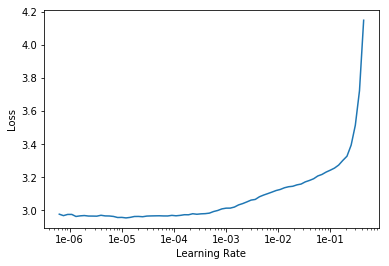

In [6]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,3.008220,3.192500,0.078829,00:30
1,2.966238,3.180777,0.081832,00:30
2,2.933129,3.165760,0.093844,00:31
3,2.900101,3.186647,0.090090,00:31
4,2.872479,3.188775,0.092342,00:30
5,2.818689,3.190061,0.102853,00:31
6,2.771041,3.211675,0.105105,00:31
7,2.723774,3.239240,0.109610,00:30
8,2.685316,3.207637,0.109610,00:30
9,2.630822,3.211132,0.115616,00:31


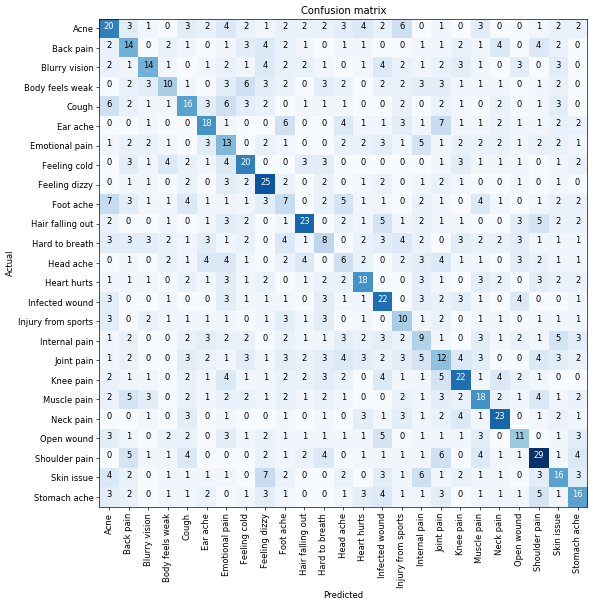

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)